# Imports

In [1]:
from utils import *
import os
import shutil
from PIL import Image
from pytorch_fid import fid_score
import copy
import torch.distributions as D

import torch.optim.lr_scheduler as lrsc
import wandb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

from config import *
config = get_configs()


device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
wandb.login()
train_loader, val_loader = get_dataset_CIFAR10(config)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


Files already downloaded and verified
Files already downloaded and verified


In [15]:
len(os.listdir("samples_32_450k"))/128

362.0

In [16]:
for i in range(128*128):
    shutil.copyfile(f'samples_32/{i}.png', f'samples_32_1/{i}.png')
    shutil.copyfile(f'samples_32_450k/{i}.png', f'samples_32_450k_1/{i}.png')

In [17]:
for i in range(128*128):
    shutil.copyfile(f'real_images/{i}.png', f'real_images_1/{i}.png')

# Sampling

In [20]:
eps_th = Unet(config)
eps_th.to(device)
ema_ = ema.ExponentialMovingAverage(eps_th.parameters(), decay=0.9999)

In [21]:
state = torch.load(config.model.savepath)
eps_th.load_state_dict(state['model'], strict=False)
ema_.load_state_dict(state['ema'])

In [22]:
ema_.copy_to(eps_th.parameters())
eps_th.eval()

Unet(
  (unet): DDPM(
    (act): SiLU()
    (all_modules): ModuleList(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=512, bias=True)
      (2): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ResnetBlockDDPM(
        (GroupNorm_0): GroupNorm(32, 128, eps=1e-06, affine=True)
        (act): SiLU()
        (Conv_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Dense_0): Linear(in_features=512, out_features=128, bias=True)
        (GroupNorm_1): GroupNorm(32, 128, eps=1e-06, affine=True)
        (Dropout_0): Dropout(p=0.1, inplace=False)
        (Conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): ResnetBlockDDPM(
        (GroupNorm_0): GroupNorm(32, 128, eps=1e-06, affine=True)
        (act): SiLU()
        (Conv_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Dense_0): Linear(in_features

# One model

In [ ]:
with torch.no_grad():
    save_callable(lambda: sample_sde(device, eps_th, config.data.image_size, config.data.num_channels, 128), "samples_32_450k", [config.data.norm_mean, config.data.norm_std], 50000)

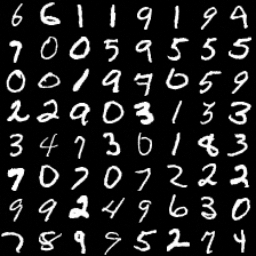

In [8]:
big_img = np.zeros((8*32,8*32),dtype=np.uint8)
for i in range(8):
    for j in range(8):
        im = Image.open(f"sampled_images/{i*8+j}.png")
        big_img[i*32:(i+1)*32, j*32:(j+1)*32] = np.array(im)
big_img = Image.fromarray(big_img)
big_img

In [15]:
save_dataloader(train_loader, 'data_1', 128*128)

In [18]:
res = fid_score.calculate_fid_given_paths(
        paths=['real_images_1', 'samples_32_450k_1'],
        batch_size=128,
        device=device,
        dims=2048
    )
print(res)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:35<00:00,  3.65it/s]


6.349314006774648


In [19]:
res = fid_score.calculate_fid_given_paths(
        paths=['real_images_1', 'samples_32_1'],
        batch_size=128,
        device=device,
        dims=2048
    )
print(res)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:37<00:00,  3.45it/s]


6.33653030912285


In [20]:
res = fid_score.calculate_fid_given_paths(
        paths=['real_images', 'samples_32'],
        batch_size=128,
        device=device,
        dims=2048
    )
print(res)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [01:51<00:00,  3.50it/s]


4.2377748437494915
